In [205]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

from mydedalustools import *    
import h5py

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


In [3]:
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

In [112]:
40e15/(6400e3)**4/(2*np.pi/86400)

3.2784908016061207e-07

In [123]:
snapshots_2level_T21_3_400  = open_h5s_wgauge('snapshots_2level_T21_locked_3_p02_400_p05',('s1','s2'))
snapshots_2level_T42_3_400  = open_h5s_wgauge('snapshots_2level_T42_locked_3_p02_400_p05',('s1','s2','s3'))
snapshots_2level_T42_3_200  = open_h5s_wgauge('snapshots_2level_T42_locked_3_p02_200_p05',('s1','s2'))
snapshots_2level_T42_10_200  = open_h5s_wgauge('snapshots_2level_T42_locked_10_p02_200_p05',('s1','s2'))

In [5]:
# Earth parameters
R_E = 6.4e6*meter
Omega_E = 2*np.pi/86400 / second
Omega = Omega_E
R = R_E
# Set Parameters
Ro_T = 2.
E = 0.02
tau_rad_nondim = 400
# Diagnostic Parameters
taurad = tau_rad_nondim/(2*Omega)
taudrag = 1/(2*Omega*E)

In [33]:
(6400e3*2*np.pi/128)**4/86400*4

4.5096801404630746e+17

In [34]:
(200e3)**4/86400*4

7.407407407407408e+16

# General characteristics

Text(0.5, 1.0, '$[u_1]$ and $[u_2]$ at the equator vs time')

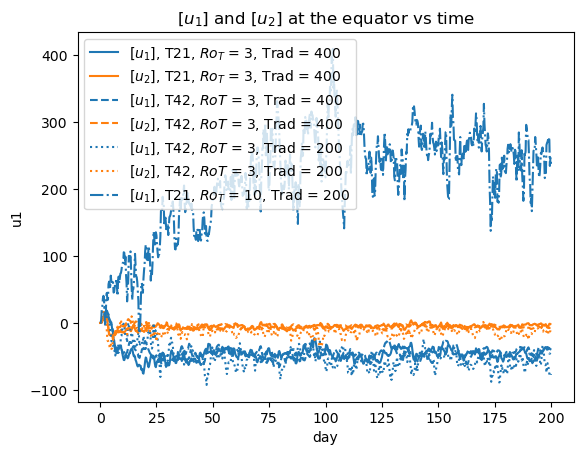

In [140]:
def zonalmeanu1_eq(u):
    return u[:,0].sel(latitude=0,method='nearest').mean(('longitude'))/(meter/second)
zonalmeanu1_eq(snapshots_2level_T21_3_400.u1).plot(x='day',label=r'$[u_1]$, T21, $Ro_T$ = 3, Trad = 400')
zonalmeanu1_eq(snapshots_2level_T21_3_400.u2).plot(x='day',label=r'$[u_2]$, T21, $Ro_T$ = 3, Trad = 400')
zonalmeanu1_eq(snapshots_2level_T42_3_400.u1).plot(x='day',label=r'$[u_1]$, T42, $RoT$ = 3, Trad = 400',linestyle='--',color='C0')
zonalmeanu1_eq(snapshots_2level_T42_3_400.u2).plot(x='day',label=r'$[u_2]$, T42, $RoT$ = 3, Trad = 400',linestyle='--',color='C1')
zonalmeanu1_eq(snapshots_2level_T42_3_200.u1).plot(x='day',label=r'$[u_1]$, T42, $RoT$ = 3, Trad = 200',linestyle=':',color='C0')
zonalmeanu1_eq(snapshots_2level_T42_3_200.u2).plot(x='day',label=r'$[u_2]$, T42, $RoT$ = 3, Trad = 200',linestyle=':',color='C1')
zonalmeanu1_eq(snapshots_2level_T42_10_200.u1).plot(x='day',label=r'$[u_1]$, T21, $Ro_T$ = 10, Trad = 200',linestyle='-.',color='C0')
plt.legend()
plt.title(r'$[u_1]$ and $[u_2]$ at the equator vs time')
#plt.xlim(0,10)

Text(0.5, 1.0, '$[u_1]$ and $[u_2]$ at the equator vs time')

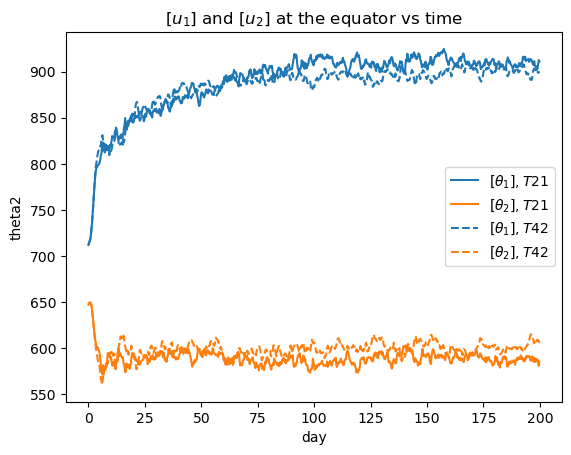

In [131]:
def zonalmeantheta1(t):
    return t.sel(latitude=0,method='nearest').mean(('longitude'))/Kelvin
zonalmeantheta1(snapshots_2level_T21_3_400.theta1).plot(x='day',label=r'$[\theta_1], T21$')
zonalmeantheta1(snapshots_2level_T21_3_400.theta2).plot(x='day',label=r'$[\theta_2], T21$')
zonalmeantheta1(snapshots_2level_T42_3_400.theta1).plot(x='day',label=r'$[\theta_1], T42$',linestyle='--',color='C0')
zonalmeantheta1(snapshots_2level_T42_3_400.theta2).plot(x='day',label=r'$[\theta_2], T42$',linestyle='--',color='C1')
plt.legend()
plt.title(r'$[u_1]$ and $[u_2]$ at the equator vs time')

Text(0.5, 1.0, '$[u_2]$')

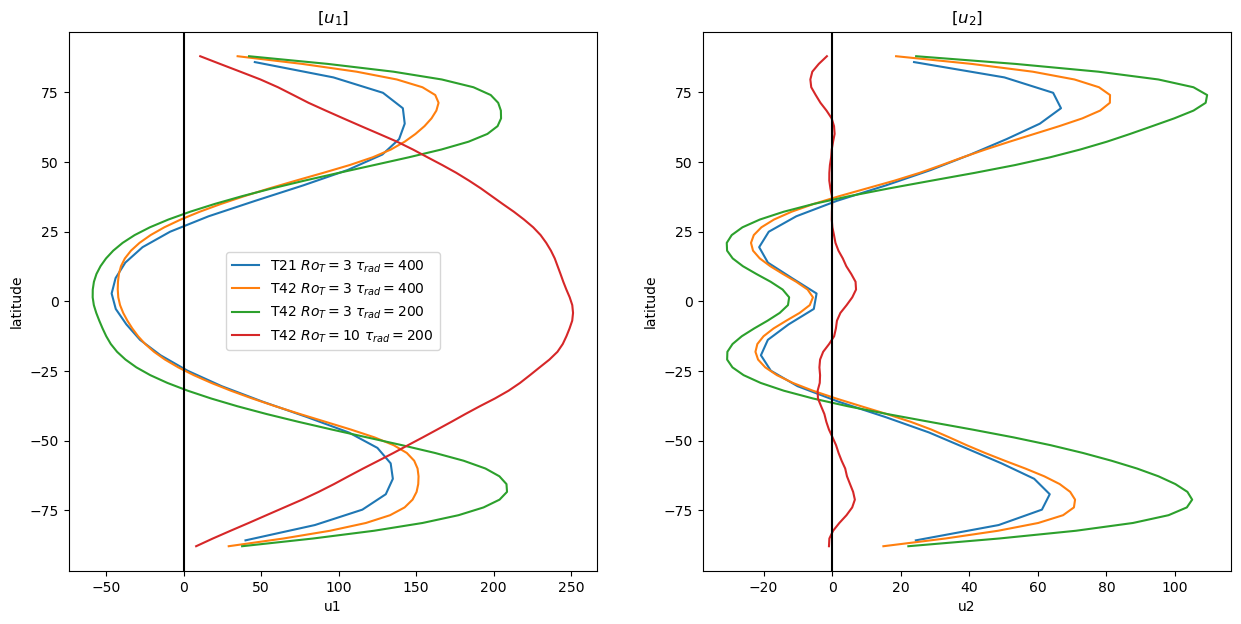

In [141]:
def final_zonalmean(u):
    return u[-5*40:].mean(('t','longitude'))/(meter/second)
_,axs = plt.subplots(1,2,figsize=(15,7))
for i,(sim,lbl) in enumerate(((snapshots_2level_T21_3_400,r"T21 $Ro_T = 3$ $\tau_{rad} = 400$"),
                              (snapshots_2level_T42_3_400,r"T42 $Ro_T = 3$ $\tau_{rad} = 400$"),
                              (snapshots_2level_T42_3_200,r"T42 $Ro_T = 3$ $\tau_{rad} = 200$"),
                              (snapshots_2level_T42_10_200,r"T42 $Ro_T = 10$ $\tau_{rad} = 200$"),
                             )):
    final_zonalmean(sim.u1[:,0]).plot(ax=axs[0],y='latitude',label=lbl)
    final_zonalmean(sim.u2[:,0]).plot(ax=axs[1],y='latitude',label=lbl)
axs[0].axvline(0.,color='k')
axs[1].axvline(0.,color='k')
axs[0].legend()
axs[0].set_title(r'$[u_1]$')
axs[1].set_title(r'$[u_2]$')

# $\theta$ & wind global structure

In [133]:
def plot_one_theta_wind(ax,theta,wind,vmin=300,vmax=370,cmap = plt.cm.viridis,scale=None,wind_disc=1):
        ((theta)/Kelvin).plot.contourf(ax=ax,y='latitude',levels=18,cmap=cmap,vmin=vmin,vmax=vmax)
        n=2*wind_disc;m=wind_disc
        ax.quiver(wind.longitude[::n],
                  wind.latitude[::m] ,
                  wind[0][::n,::m].T,
                  -wind[1][::n,::m].T,
                  scale=scale)

def plot_theta_wind(theta,wind,title,vmin=300,vmax=370,cmap = plt.cm.viridis,scale=None,wind_disc=1,ndays_avg=30):
    _,axs=plt.subplots(2,3,figsize=(20,10))
    axs=axs.reshape(-1)
    for i,time in enumerate(np.linspace(0,len(theta.t)-1,6)):
        if i>4:
            break
        time=int(time)
        plot_one_theta_wind(axs[i],theta[time],wind[time],vmin,vmax,cmap,scale,wind_disc)
        axs[i].set_title("time = %.1f days"%sol.day[time])
    plot_one_theta_wind(axs[-1],theta[-ndays_avg*4:].mean('t'),wind[-ndays_avg*4:].mean('t'),vmin,vmax,cmap,scale,wind_disc)
    axs[-1].set_title("avg last %i days"%ndays_avg)
    plt.suptitle(title,fontsize=25)
    


Text(0.5, 1.0, 'Avg days 170-200')

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


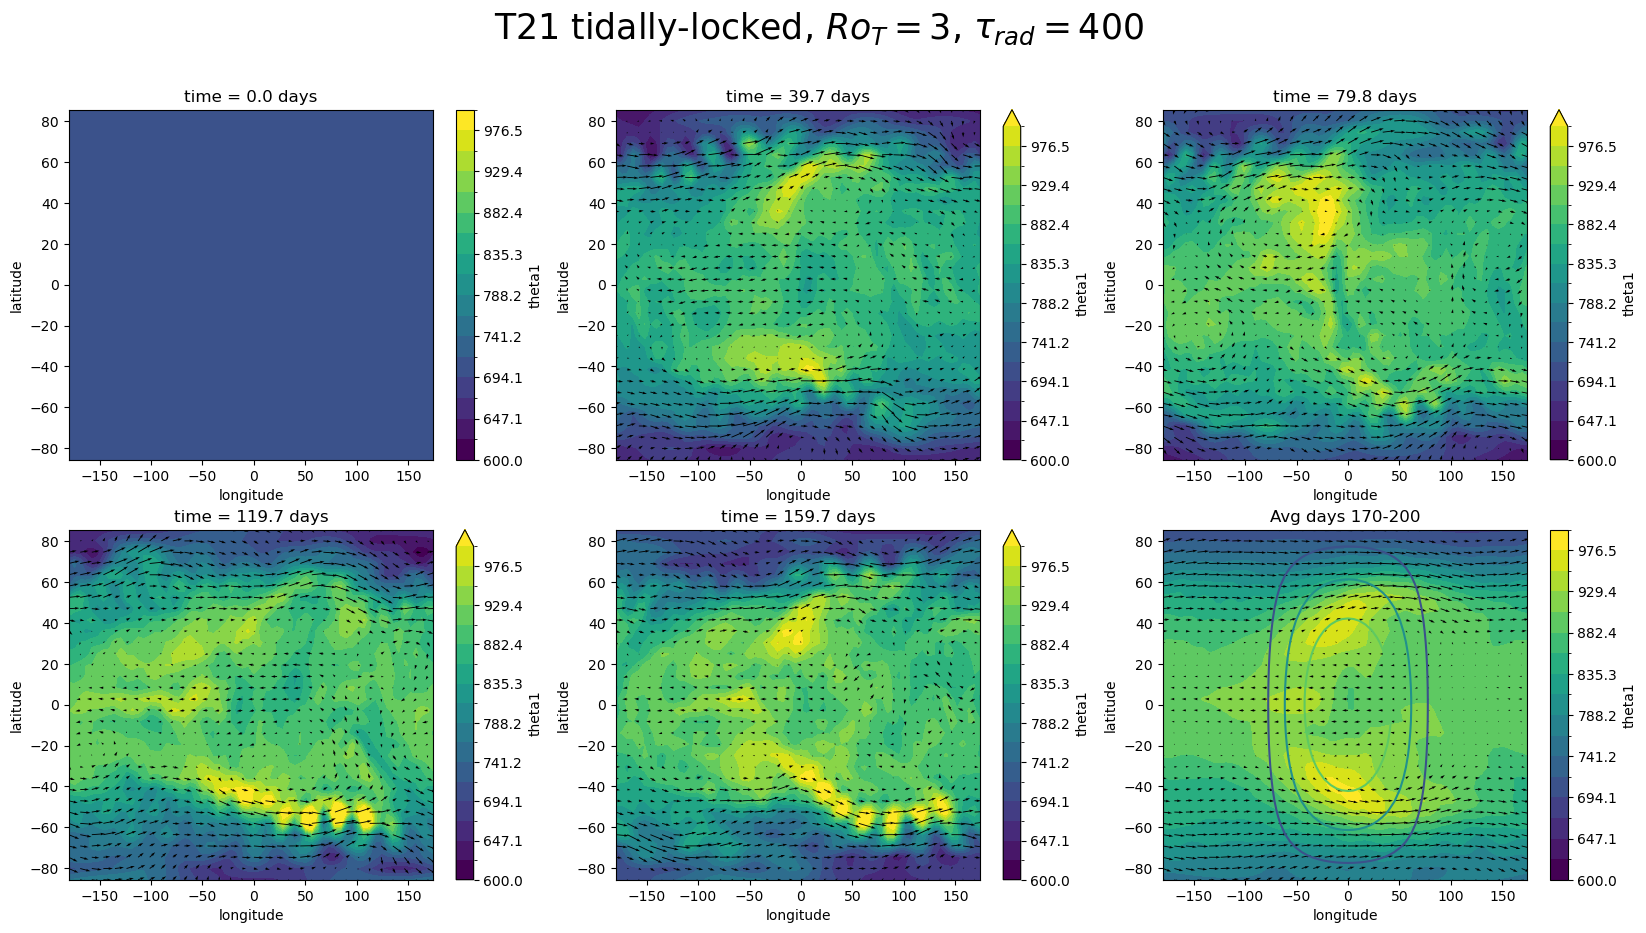

In [136]:
sol=snapshots_2level_T21_3_400
plot_theta_wind(sol.theta1,sol.u1,r'T21 tidally-locked, $Ro_T=3$, $\tau_{rad} = 400$',vmin=600,vmax=1000)
sol.theta1E[0].plot.contour(y='latitude',levels=np.linspace(10,sol.theta1E[0].max(),5))
plt.title("Avg days 170-200")

Text(0.5, 1.0, 'Avg days 170-200')

/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


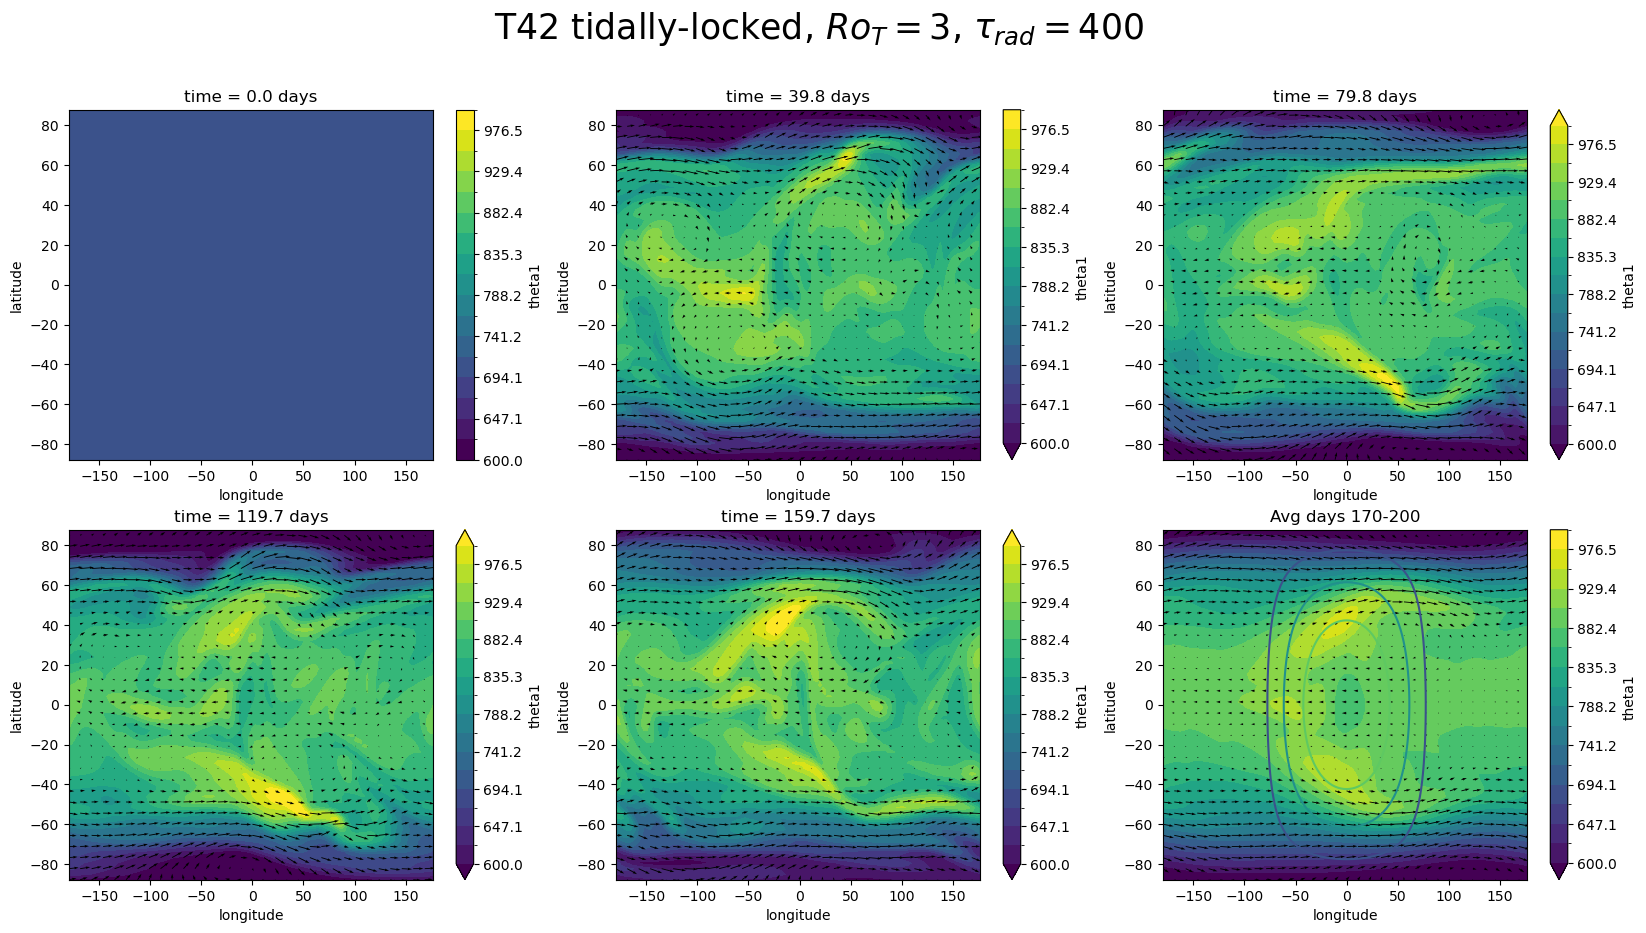

In [137]:
sol=snapshots_2level_T42_3_400
plot_theta_wind(sol.theta1,sol.u1,r'T42 tidally-locked, $Ro_T=3$, $\tau_{rad} = 400$',vmin=600,vmax=1000,wind_disc=2)
sol.theta1E[0].plot.contour(y='latitude',levels=np.linspace(10,sol.theta1E[0].max(),5))
plt.title("Avg days 170-200")

Text(0.5, 1.0, 'T42 $Ro_T = 10$ $\\tau_{rad} = 200$')

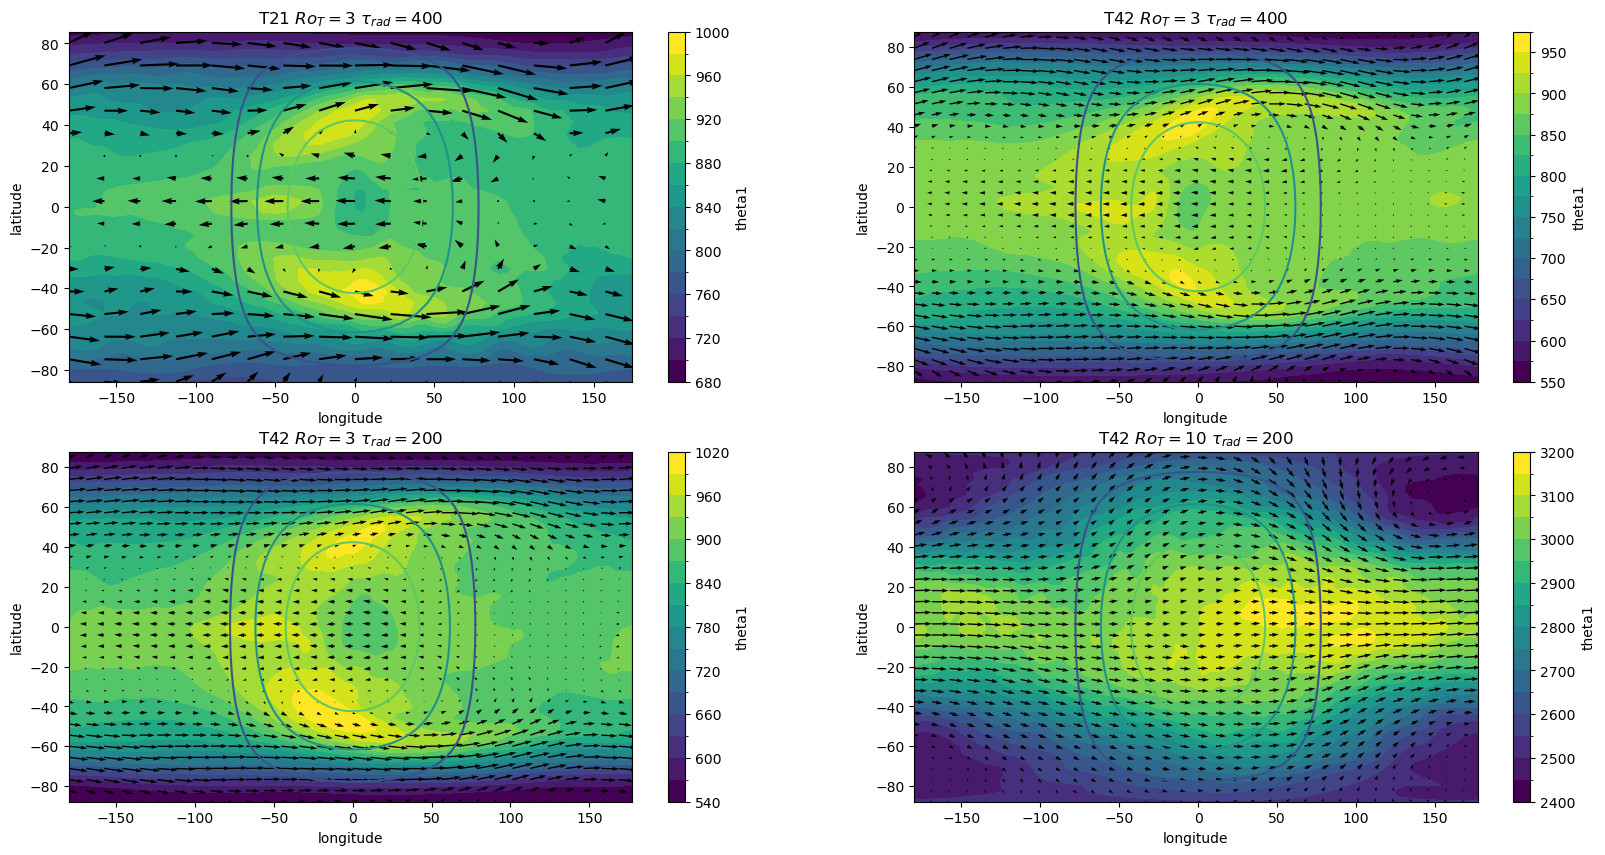

In [142]:
_,axs=plt.subplots(2,2,figsize=(20,10))
axs=axs.reshape(-1)
for i,sol in enumerate((snapshots_2level_T21_3_400,       
                        snapshots_2level_T42_3_400,       
                        snapshots_2level_T42_3_200,    
                        snapshots_2level_T42_10_200,
                       )):
    plot_one_theta_wind(axs[i],sol.theta1[-80:].mean('t'),sol.u1[-80:].mean('t'),vmin=None,vmax=None,wind_disc=2)
    sol.theta1E[0].plot.contour(ax=axs[i],y='latitude',levels=np.linspace(1,sol.theta1E[0].max(),5))
axs[0].set_title(r"T21 $Ro_T = 3$ $\tau_{rad} = 400$")
axs[1].set_title(r"T42 $Ro_T = 3$ $\tau_{rad} = 400$")
axs[2].set_title(r"T42 $Ro_T = 3$ $\tau_{rad} = 200$")
axs[3].set_title(r"T42 $Ro_T = 10$ $\tau_{rad} = 200$")

# Eddy contributions to superrotation

In [143]:
def emfc_hz(sol):
    lat_rad = sol.latitude*np.pi/180
    sol = sol.assign_coords({'lat_rad':lat_rad})
    u1_xt =  sol.u1[:,0].mean(('t','longitude'))
    v1_xt = -sol.u1[:,1].mean(('t','longitude'))
    u2_xt =  sol.u2[:,0].mean(('t','longitude'))
    v2_xt = -sol.u2[:,1].mean(('t','longitude'))
    u1_tstar = sol.u1[:,0].mean('t') - u1_xt
    v1_tstar = -sol.u1[:,1].mean('t') - v1_xt
    u2_tstar = sol.u2[:,0].mean('t') - u2_xt
    v2_tstar = -sol.u2[:,1].mean('t') - v2_xt
    mmc = ((u1_xt*v1_xt+u2_xt*v2_xt)/2 * np.cos(lat_rad)**2).differentiate('lat_rad')/(R*np.cos(lat_rad)**2)
    standing = ((u1_tstar*v1_tstar+u2_tstar*v2_tstar).mean('longitude')/2 * np.cos(lat_rad)**2).differentiate('lat_rad')/(R*np.cos(lat_rad)**2)
    full = (((sol.u1[:,0]*(-sol.u1[:,1]) + sol.u2[:,0]*(-sol.u2[:,1]))/2).mean(('t','longitude')) * np.cos(lat_rad)**2).differentiate('lat_rad')/(R*np.cos(lat_rad)**2)
    transient = full - mmc - standing
    drag = -u2_xt/2/taudrag
    return -full/(meter/second**2),-mmc/(meter/second**2),-standing/(meter/second**2),-transient/(meter/second**2),-drag/(meter/second**2)
    

Text(0.5, 1.0, 'T42 superrotating simulation, last 50 days')

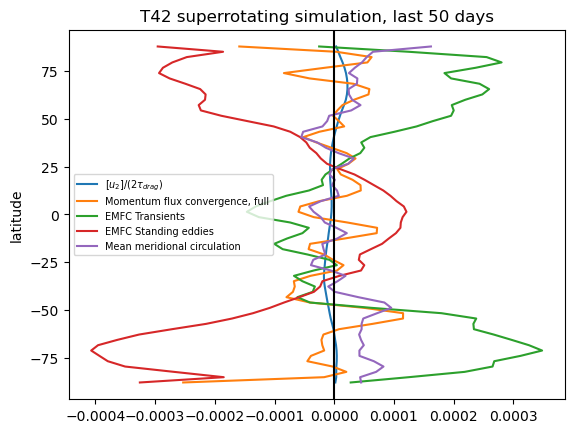

In [146]:
emfc_full, emfc_mmc, emfc_standing, emfc_transient, mean_drag = emfc_hz(snapshots_2level_T42_10_200.sel(t=slice(-200,None)))
mean_drag     .plot(y="latitude",label=r"$[u_2]/(2\tau_{drag})$")
emfc_full     .plot(y="latitude",label="Momentum flux convergence, full")
emfc_transient.plot(y="latitude",label=r"EMFC Transients")
emfc_standing .plot(y="latitude",label=r"EMFC Standing eddies")
emfc_mmc      .plot(y="latitude",label=r"Mean meridional circulation")
plt.axvline(0.,color='k')
plt.legend(fontsize=7)
plt.title("T42 superrotating simulation, last 50 days")




# Spectral analysis

In [287]:
all_tasks = ('u1','u2','Phi1','theta1','theta2','Phi2','omega','vorticity_1','vorticity_2','theta1E','theta2E','dy_uv','fzetav','omegaubar','omegauhat','dy_uv_b','fzetav_b','omegaubar_b','omegauhat_b')
snapshots_2level_T42_10_200_ = thetaphi_to_latlon(xr.merge(d3.load_tasks_to_xarray(SNAPSHOTS_DIR+'%s/%s_%s.h5'%(name,name,'s3'),tasks=all_tasks).values()))


In [288]:
with h5py.File(SNAPSHOTS_DIR+'%s/%s_%s.h5'%(name,name,'s3'), mode='r') as file:
    # Load datasets
    u1_mixed = file['tasks']['u1_mixed']
    u1_mixed_xr = xr.DataArray(u1_mixed[:,:,::2]+1j*u1_mixed[:,:,1::2],coords={'t'    :('t',u1_mixed.dims[0]['sim_time'][:]),
                                                   'kphi' :('kphi',u1_mixed.dims[2]['kphi'][::2,0]    ),
                                                   'theta':('theta',u1_mixed.dims[3]['theta'][:])
                                                  },
                              dims = ['t','component','kphi','theta']).sortby('kphi')
    u1_mixed_xr = theta_to_lat(u1_mixed_xr)

In [293]:
uprimevprime = np.real(u1_mixed_xr[:,0]*np.conj(u1_mixed_xr[:,1])).sum('kphi').mean('t')

In [296]:
coslat=np.cos(uprimevprime.latitude*np.pi/180)
testmc = (uprimevprime*coslat**2).differentiate('latitude')/(R*coslat**2)

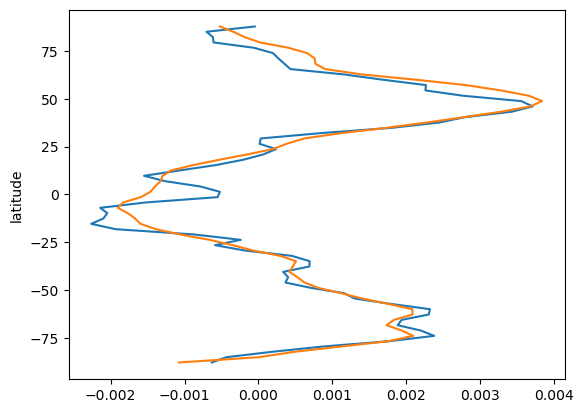

In [301]:
snapshots_2level_T42_10_200_['dy_uv'].mean(('t','longitude')).plot(y='latitude')
(-testmc*8*np.pi).plot(y='latitude')


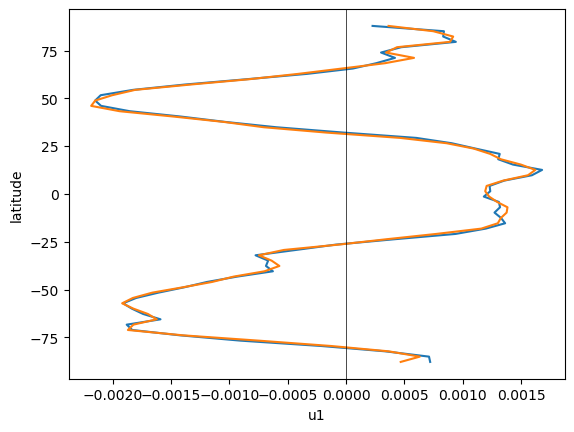

In [289]:
#snapshots_2level_T42_10_200_['dy_uv'].mean(('t','longitude')).plot(y='latitude')
#(snapshots_2level_T42_10_200_['u1'][:,1].mean(('t','longitude'))*2*Omega*np.cos(snapshots_2level_T42_10_200_.theta)).plot(y='latitude')
#snapshots_2level_T42_10_200_['omegaubar'].mean(('t','longitude')).plot(y='latitude')

dy_uv     = snapshots_2level_T42_10_200_['dy_uv'][:].mean(('t','longitude')) 
fv        = (-snapshots_2level_T42_10_200_['u1'][:,1].mean(('t','longitude'))*2*Omega*np.cos(snapshots_2level_T42_10_200_.theta))
omegaubar = snapshots_2level_T42_10_200_['omegaubar'].mean(('t','longitude'))


#dy_uv.plot(y='latitude')
#fv.plot(y='latitude')
#omegaubar.plot(y='latitude')


(-dy_uv+fv-omegaubar).plot(y='latitude')

u1t = snapshots_2level_T42_10_200_['u1'][:,0].mean('longitude')
((u1t[-1]-u1t[0])/(24*hour)).plot(y='latitude')

plt.axvline(0.,color='k',linewidth=0.5)

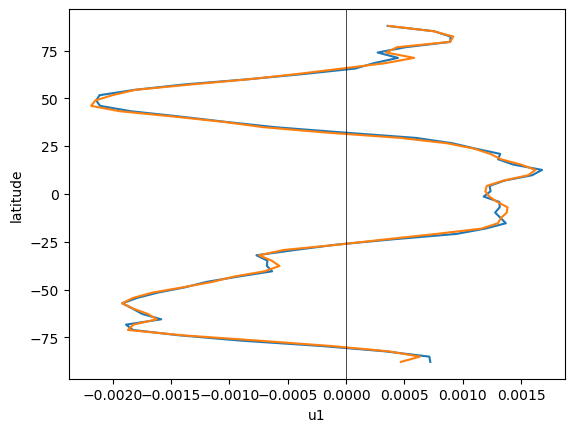

In [290]:
#snapshots_2level_T42_10_200_['fzetav'].mean(('t','longitude')).plot(y='latitude')
#snapshots_2level_T42_10_200_['omegauhat'].mean(('t','longitude')).plot(y='latitude')
(snapshots_2level_T42_10_200_['fzetav'].mean(('t','longitude')) + snapshots_2level_T42_10_200_['omegauhat'].mean(('t','longitude'))).plot(y='latitude')

u1t = snapshots_2level_T42_10_200_['u1'][:,0].mean('longitude')
((u1t[-1]-u1t[0])/(24*hour)).plot(y='latitude')

plt.axvline(0.,color='k',linewidth=0.5)